# A Transfer Learner with `fastai`

This notebook tackels the problem of classifying industries with a transfer learner. It's a combination of two nlp-models: 
- `language` which was pretrained on Wikipedia articles to predict the next word
- `classifer` model 

Thereby it follows [this](https://docs.fast.ai/tutorial.text.html) `fastai` tutorial. 



### Load Packages

In [1]:
!pip install ndjson --quiet
!pip install fastai --upgrade --quiet

     |████████████████████████████████| 189 kB 4.2 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 


In [2]:
import pandas as pd
import ndjson
from fastai.text.all import *
from google.colab import drive

### Load Datasets

Training dataset

In [ ]:
# Mount Google Drive
drive.mount('/gdrive')
path_train = Path('/gdrive/MyDrive/industry_data_processed/data/final/df_train_de_sentiment.ndjson')

with open(path_train) as f:
    data = ndjson.load(f)
df_train = pd.DataFrame(data)
df_train.head(n=2)

Mounted at /gdrive


,url,industry,industry_label,img_alt,h1,h2,h3,strong,bold,lang_code,figcaption,pure_text,title,concatenated,sentiment_analysis
0,http://www.kaiser-personal-service.de,137,Human Resources,,,aktuell Stellenangebot,,,,de,,Kaiser Personal Service Impressum Datumenschutz Bewerbung Kp Darmstadt Kp Rheinland suchen Arbeit Staplerfahrer bewerben suchen Arbeit Verkäufer bewerben suchen Arbeit Telefonist bewerben aktuell Stellenangebot Standort wählen Kp Darmstadt Kp Rheinland Kcm Königsfeld Kommunikationselektronik Fernmeldemonteur Elektriker Elektronik Elektronik Raum Darmstadtab Sofortkennziffer Dafmjob Detailsstaplerfahrer Staplerfahrer Biebesheimab Sofortkennziffer Dastjob Detailsmitarbeiter Oberflächentechnik Helfer groß Umstadtab Sofortkennziffer Guotjob Detailssachbearbeiter Tz Zollkenntnissensachbearbeite...,Kaiser Personal Service,aktuell Stellenangebot de Kaiser Personal Service Impressum Datumenschutz Bewerbung Kp Darmstadt Kp Rheinland suchen Arbeit Staplerfahrer bewerben suchen Arbeit Verkäufer bewerben suchen Arbeit Telefonist bewerben aktuell Stellenangebot Standort wählen Kp Darmstadt Kp Rheinland Kcm Königsfeld Kommunikationselektronik Fernmeldemonteur Elektriker Elektronik Elektronik Raum Darmstadtab Sofortkennziffer Dafmjob Detailsstaplerfahrer Staplerfahrer Biebesheimab Sofortkennziffer Dastjob Detailsmitarbeiter Oberflächentechnik Helfer groß Umstadtab Sofortkennziffer Guotjob Detailssachbearbeiter...,0.00
1,http://www.brandseven.com,96,Information Technology and Services,Brandseven Energy Cockpit Innovation Lab Brandseven Go Remote Biohymethcontrol Online Präsentation,Maßgeschneiderte Vertriebstool Stadtwerk Evu s,Brandseven Go Remote Biohymethcontrol richtig erklären einfach Online Survival Analyse Kausales Modell Basisanalyse,Energy Cockpit Edition,Beispiel Gedankenexperiment Intervention Ergebnis,,de,,Brandseven digital Lösung Energiewirtschaft seit Jahr Inhalt springen Startenergy Cockpit Übersicht Customer Data Energy Price Energy lib Energy Sales Innovation Labüber Unspartnerjobskontakt Start Energy Cockpit Übersicht Customer Data Energy Price Energy lib Energy Sales Innovation Lab Partner Job Kontakt Energy Cockpit Edition Maßgeschneiderte Vertriebstool Stadtwerk Evu s Cloud basieren fortschrittlich Detail erfahren Energy Cockpit übernehmen Steuer Cloudbasierte Tools neu Bestandskunde Pricing Controlling Vertriebssteuerung vereinen Cockpit individuell anpassen erfahren Blick Kulisse...,Brandseven digital Lösung Energiewirtschaft seit Jahr,Brandseven Energy Cockpit Innovation Lab Brandseven Go Remote Biohymethcontrol Online Präsentation Maßgeschneiderte Vertriebstool Stadtwerk Evu s Brandseven Go Remote Biohymethcontrol richtig erklären einfach Online Survival Analyse Kausales Modell Basisanalyse Energy Cockpit Edition Beispiel Gedankenexperiment Intervention Ergebnis de Brandseven digital Lösung Energiewirtschaft seit Jahr Inhalt springen Startenergy Cockpit Übersicht Customer Data Energy Price Energy lib Energy Sales Innovation Labüber Unspartnerjobskontakt Start Energy Cockpit Übersicht Customer Data Energy Price Energy...,-0.11


 Test dataset

In [3]:
# Mount Google Drive
drive.mount('/gdrive')
path_test = Path('/gdrive/MyDrive/industry_data_processed/data/final/df_test_de_sentiment.ndjson')

with open(path_test) as f:
    data = ndjson.load(f)
df_test = pd.DataFrame(data)
df_test.head(n=2)

Mounted at /gdrive


,url,industry,industry_label,img_alt,h1,h2,h3,strong,bold,lang_code,figcaption,pure_text,title,concatenated,sentiment_analysis
0,http://www.expert.de,133,Wholesale,Expert Logo Expert Logo Expert Logo Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Bild Artikel Aktion Symbol v Motorhead Origin Akkuhandstaubsauger Artikel Aktion Symbol galaxy a Prism Crush Black Otelo Allnet Classic einmalig p Laufz Artikel Aktion Symbol galaxy Tab s leiden Wi fi Gray Tablet Workforce Wf Dwf Schwarz Multifunktionsdrucker Artikel Aktion Symbol Kaffeevollautomat Te f De Waschmaschine Wan Artikel Effizienz Skala Nespresso Kapselmaschine Env Vertuonext Basic Weiß Staubsauger compact Power Cyclonic Anima...,,Highlight,,registrieren Angebot Kinoerlebnis Haus kaufen Upgrade Homeoffice erfahren Toni ® kaufen gehören zusammen sparen kaufen perfekt Wäsche Umwelt kaufen Happy Payday erfahren Rabatt Microsoft Family sichern kaufen neu Expert Reparaturservice Mobilgeräte ganz bequem Online abwickeln work From Home Sonos Roam Bosch Cashback Kartenzahlung leicht machen Lg Soundbar kaufen Samsung Neo Qled aktuell Aktion Gewinnspiel Techniktrend Experte Beratung Reparatur Service Montag Service Finanzierung Service Altgerät Entsorgung liefern Abholservice Expert Vorteil Expert Newsletter kostenlos Registrierung Akze...,,de,,Elektromarkt Nähe Online Shop Expert Warenkorb Liegen Artikel Warenkorb Warenkorb Warenkorb Liegen Artikel Warenkorb Warenkorb Fachmarkt Fachmarkt auswählen Fachmarkt finden Warenkorb Liegen Artikel Warenkorb Warenkorb Produkt Tv Audio Fernseher Lcd Led Fernseher Oled Tv Qled Tv Nanocell Tv Beamer Beamer Zubehör Tv Halterung Tv Stand Hdmi Switches splittern Fernbedienung Ir Verlängerung Brille Streaming Player Tv Zubehör Dvd Blu Ray Player k Blu Ray Player Blu Ray Player Rekord Dvd Player Rekord tragbar Dvd Player Empfangstechnik Sat Receiver Dvb T Receiver Kabel Receiver Ip Tv Mediaboxen ...,Elektromarkt Nähe Online Shop Expert,Expert Logo Expert Logo Expert Logo Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Angebot Woche Kw Bild Artikel Aktion Symbol v Motorhead Origin Akkuhandstaubsauger Artikel Aktion Symbol galaxy a Prism Crush Black Otelo Allnet Classic einmalig p Laufz Artikel Aktion Symbol galaxy Tab s leiden Wi fi Gray Tablet Workforce Wf Dwf Schwarz Multifunktionsdrucker Artikel Aktion Symbol Kaffeevollautomat Te f De Waschmaschine Wan Artikel Effizienz Skala Nespresso Kapselmaschine Env Vertuonext Basic Weiß Staubsauger compact Power Cyclonic Anima...,0.31
1,http://www.weight-watchers.de,13,Medical Practice,neu Meinww Meinww mobil Vorschau Fiton Video Workouts ww App mobil Vorschau Rezept ww App mobil Vorschau Mitglied Post ww Community mobil Vorschau individuell Zielsetzung ww App mobil Vorschau Fiton Video Workouts ww App mobil Vorschau Rezept ww App mobil Vorschau Mitglied Post ww Community mobil Vorschau individuell Zielsetzung ww App mobil Vorschau Fiton Video Workouts ww App mobil Vorschau Rezept ww App Junge Frau blond Haaren sitzen lächelnd Handy Hand Junge Frau Rote Haaren lang Rock halten Kaffeebecher Hand Frau lang Haar stehen Küche schneiden Kürbis sportlich gekleidet Frau stehen ...,abnehmen ww Weight Watchers ww Deutschland,kurz Zeit Studios Ort vorübergehend schließen Workshop Lauf wohnen virtuell Termin Workshop Suche haben Frage Antwort,bereit loslegen Mitglied vormachen,ww App kurz Zeit Monat kostenlos ww Pro “ exklusiv Community live On demand Premiuminhalte kurz Zeit Monat kostenlos ww Coach Workshop Ort Studio virtuell kurz Zeit Monat kostenlos Neue Fragebogen individuell Bedürfnis Vorliebe abstimmen,,de,,abnehmen ww Weight Watchers ww Deutschland direkt Inhaltzum Ende Seiteso funktionieren Spreiserezepte Tippsworkshop Findenshoplog Instartenso funktionieren Smeinww Essenbewegenmindsetschlaferfolgefreunde Einladenpreisedigital Digital Unlimited Workshop Digitalrezepte Tippsworkshop Find

### Build Model

#### Preperation

In [ ]:
path_df = '/gdrive/MyDrive/industry_data_processed/data/final/df_train_de_sentiment.ndjson'
path_model = '/gdrive/MyDrive/industry_data_processed/models/dl_fastai/'

Thes `Transfer-Learner` will be trained on the `pure_text` column and the `sentiment_analysis`. 

In [13]:
predicting_cols = ['pure_text', 'sentiment_analysis']

Create `DataLoader` for the first pretrained model: `Language-Model-learner`

Since we are using a `Language-Model-learner` we have to set `is_lm=True`

In [ ]:
dls_lang = TextDataLoaders.from_df(
    df=df_train,
    is_lm=True,
    bs=32,
    path=path_df,
    text_col=predicting_cols,
    label_col='industry_label',
    seed=25,
    valid_pct=0.2
)

Create `Language-Model-Learner`

For both learners we will be using the `AWD_LSTM` model.

In [ ]:
learn_lang = language_model_learner(dls_lang, AWD_LSTM, metrics=accuracy, path=path_model)

SuggestedLRs(valley=0.010964781977236271)

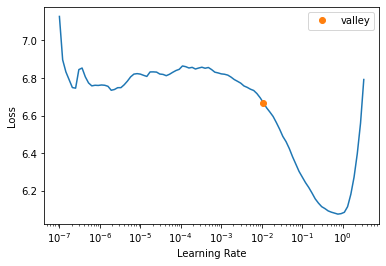

In [ ]:
learn_lang.lr_find()

In [ ]:
learn_lang.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.952515,3.808471,0.510751,20:27


Unfreeze `Language-Model-Learner` for finetuning:

In [ ]:
learn_lang.unfreeze()

In [ ]:
learn_lang.fit(8, 1e-2)
learn_lang.save_encoder('learn_lang_de_sent')

epoch,train_loss,valid_loss,accuracy,time
0,3.640649,3.903164,0.506584,22:05
1,3.701613,3.809738,0.511625,22:14
2,3.625432,3.770810,0.514406,22:25
3,3.573737,3.749691,0.515890,22:04
4,3.601388,3.741146,0.516864,22:00
5,3.584799,3.734267,0.517183,22:21


epoch,train_loss,valid_loss,accuracy,time
0,3.640649,3.903164,0.506584,22:05
1,3.701613,3.809738,0.511625,22:14
2,3.625432,3.770810,0.514406,22:25
3,3.573737,3.749691,0.515890,22:04
4,3.601388,3.741146,0.516864,22:00
5,3.584799,3.734267,0.517183,22:21
6,3.571754,3.726374,0.518044,22:24
7,3.390404,3.721374,0.518166,22:36


Create `DataLoader` for `Text-Classifier-Learner`

To train the `Text-Classifier-Learner` on the same vocab as the `Language-Model-Learner` use: `dls_lang.vocab`

In [ ]:
dls_class = TextDataLoaders.from_df(
    df=df_train,
    text_vocab=dls_lang.vocab,
    bs=32,
    path=path_df,
    text_col=predicting_cols,
    label_col='industry_label',
    seed=25,
    valid_pct=0.2
)

Create `Text-Classifier-Learner`

In [ ]:
learn_class = text_classifier_learner(dls_class, AWD_LSTM, metrics=accuracy,  path=path_model)

Create `Transfer-Learner` 
<br/>Therefore we have to load the previously saved `Encoder` of the `Language-Model-Learner` onto the `Text-Classifier-Learner`

In [ ]:
learn_class = learn_class.load_encoder('learn_lang_de_sent')

SuggestedLRs(valley=0.0014454397605732083)

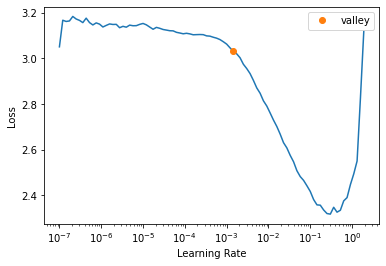

In [ ]:
learn_class.lr_find()

In [ ]:
learn_class.fit(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.013262,0.908331,0.720321,03:38


Since the first fit looks promessing we will unfreeze the model layer by layer and continue fitting.

In [ ]:
learn_class.freeze_to(-2)
learn_class.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.919699,0.854763,0.733710,04:15


In [ ]:
learn_class.freeze_to(-3)
learn_class.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.877684,0.804935,0.752752,05:56


In [ ]:
learn_class.unfreeze()
learn_class.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.810297,0.781150,0.751265,07:31
1,0.725628,0.769174,0.753347,07:32


In [ ]:
learn_class.export('Transfer_learner_sent.pkl')

In [5]:
from fastai.learner import load_learner
file_path = '/gdrive/MyDrive/industry_data_processed/models/dl_fastai/Transfer_learner_sent.pkl'

fastai_transfer = load_learner(file_path)

In [30]:
test_dl = fastai_transfer.dls.test_dl(df_test.concatenated) # Create a test dataloader

In [ ]:
preds, y = fastai_transfer.get_preds(dl=test_dl)

In [ ]:
interp = ClassificationInterpretation.from_learner(fastai_transfer)
interp.plot_confusion_matrix(title='Confusion matrix')

In [ ]:
f1_score = F1Score(preds)
f1_score